In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from shapley.transform import ThresholdTransform, AddNoise,DetachWhite


/data/jong980812/anaconda3/envs/asd/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torchvision.models as models
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torch.nn as nn

model=models.efficientnet_b1(pretrained=True)
model.classifier[1] = torch.nn.Linear(1280, 2)
model.classifier = nn.Identity()

finetune='/data/jong980812/project/mae/result_after_shapley/mw/binary_240_0.98_224168/OUT/01/checkpoint-29.pth'
checkpoint = torch.load(finetune, map_location='cpu')
print("Load pre-trained checkpoint from: %s" % finetune)
checkpoint_model = checkpoint['model']
state_dict = model.state_dict()
msg = model.load_state_dict(checkpoint_model, strict=False)
print(msg)
model.eval()
def set_conv_padding_mode(model, padding_mode='zeros'):
  for name, layer in model.named_modules():
      if isinstance(layer, torch.nn.Conv2d):
          layer.padding_mode = padding_mode
set_conv_padding_mode(model,padding_mode='zeros')

transform=transforms.Compose([
    transforms.Resize((224,224)),
    # transforms.RandomCrop((224,224)),
    # transforms.Grayscale(3),
    # transforms.RandomInvert(1),
    transforms.ToTensor(),
    ThresholdTransform(240),
    # AddNoise(50)
    # transforms.Normalize(mean=[0.5, 0.5, 0.5],
    #                         std=[0.5,0.5,0.5])
    ])
dataset = datasets.ImageFolder('/local_datasets/ai_hub/ai_hub_sketch_mw/01/val/', transform=transform)
model.to('cuda')
dataloader =DataLoader(dataset,500,True)
feature_map= nn.Sequential(*(list(model.children())[0][:9])) # input to penultimate layer


Load pre-trained checkpoint from: /data/jong980812/project/mae/result_after_shapley/mw/binary_240_0.98_224168/OUT/01/checkpoint-29.pth
_IncompatibleKeys(missing_keys=[], unexpected_keys=['classifier.1.weight', 'classifier.1.bias'])


In [3]:
dataset

Dataset ImageFolder
    Number of datapoints: 2800
    Root location: /local_datasets/ai_hub/ai_hub_sketch_mw/01/val/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               binaryTH:240
           )

In [4]:
(dataset[0][0]-dataset[555][0]).mean()

tensor(-0.0114)

In [3]:


features =[]
labels = []
model.eval()
torch.cuda.empty_cache()

with torch.no_grad():
    for img, label in dataloader:
        img = img.to('cuda')
        feature = model(img)
        features.append(feature.cpu())
        labels.append(label.cpu())
features = torch.cat(features).numpy()
labels = torch.cat(labels).numpy()


    

In [4]:
model.eval()
pca = PCA(n_components=3)
a = pca.fit_transform(features)


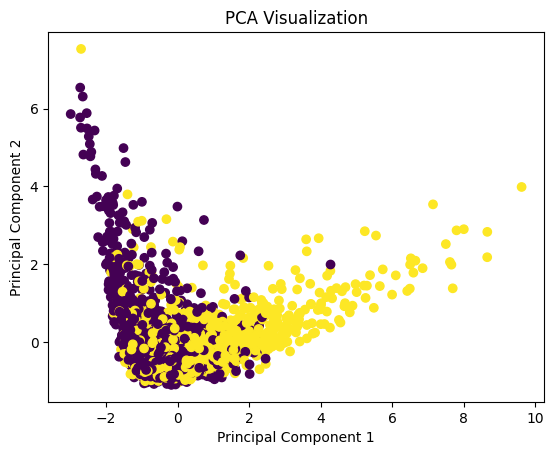

In [8]:
import matplotlib.pyplot as plt


# 시각화
plt.scatter(a[:, 0], a[:, 1],c=labels)  # 클래스 레이블을 색상으로 사용
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization')
plt.show()

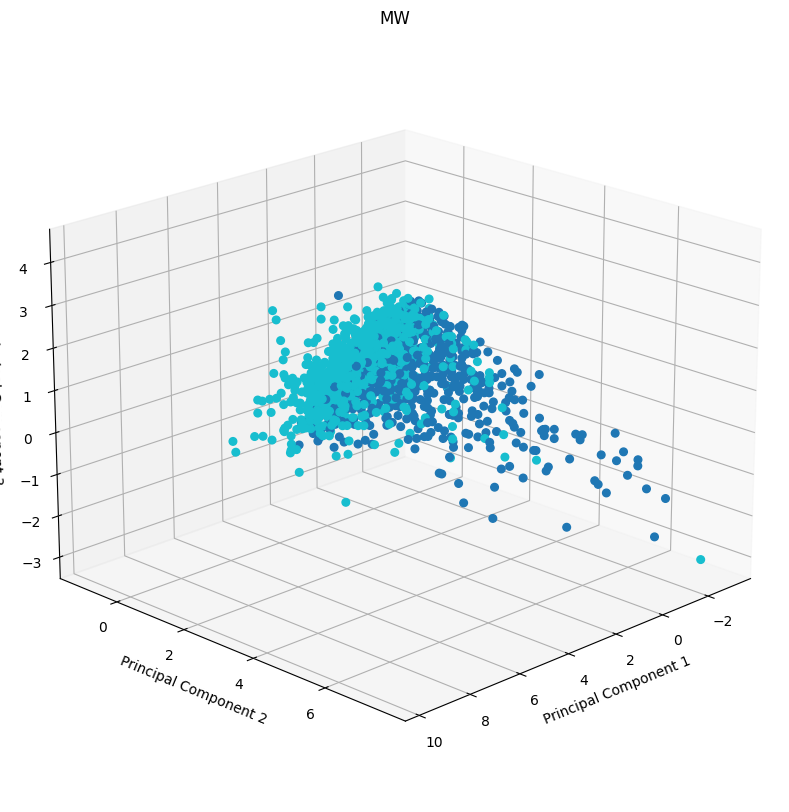

In [5]:
fig = plt.figure(figsize=(15, 10))  # 그래프 크기 설정
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(a[:, 0], a[:, 1], a[:, 2], c=labels, cmap='tab10', alpha=1.0,s=30)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.title('MW')
ax.view_init(elev=20, azim=45,) 
# ax.set_xlim(-3, 3)  # X 축 범위
# ax.set_ylim(-3, 3)  # Y 축 범위
# ax.set_zlim(-3, 3) 
plt.show()